# Scoring of MCQ and FCQ from Study 1 data

We will read in raw response data, combine with the MCQ and FCQ questions, and score each. This will result in a $\log(k)$ score for each participant for the MCQ and the FCQ.

MCQ = Kirby 27-item questionnaire.

FCQ = Hendrickson et al (2015)

Information about use of `pm.Data` containers can be found here https://docs.pymc.io/notebooks/data_container.html. 

In [1]:
# Install Black autoformatter with: pip install nb-black
%load_ext lab_black

import pymc3 as pm

import numpy as np
import pandas as pd

# plotting
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14})

# Define options

In [2]:
SEED = 12345

# Define sampler options
sample_options = {
    "tune": 2000,
    "draws": 2000,
    "chains": 2,
    "cores": 2,
    "nuts_kwargs": {"target_accept": 0.95},
    "random_seed": SEED,
}

# Define plotting functions

In [3]:
def plot_discount_func(ax, data, trace):
    delays = np.linspace(0, np.max(data.DB.values), 1000)

    # plot posterior mean
    k = np.exp(np.mean(trace["logk"]))
    ax.plot(delays, discount_function(delays, k), lw=4)

    # plot 95% region
    p = np.percentile(np.exp(trace["logk"]), [5 / 2, 100 - (5 / 2)])
    ax.fill_between(
        delays,
        discount_function(delays, p[0]),
        discount_function(delays, p[1]),
        alpha=0.2,
    )

In [4]:
def plot_data(data, ax=None):

    if ax is None:
        ax = plt.gca()

    D = data["R"] == 1
    I = data["R"] == 0

    if np.sum(D) > 0:
        ax.scatter(
            x=data["DB"][D],
            y=data["RA"][D] / data["RB"][D],
            c="k",
            edgecolors="k",
            label="chose delayed prospect",
        )
    if np.sum(I) > 0:
        ax.scatter(
            x=data["DB"][I],
            y=data["RA"][I] / data["RB"][I],
            c="w",
            edgecolors="k",
            label="chose immediate prospect",
        )

    ax.set(
        xlabel="DB", ylabel="RA/RB", ylim=[0, 1], xlim=[0, 1.05 * np.max(data["DB"])]
    )

In [5]:
def plot_questions(data, ax=None):

    if ax is None:
        ax = plt.gca()

    ax.scatter(x=data["DB"], y=data["RA"] / data["RB"])
    ax.set(
        xlabel="DB", ylabel="RA/RB", ylim=[0, 1], xlim=[0, 1.05 * np.max(data["DB"])]
    )

# Load raw data

In [6]:
data = pd.read_csv("../02 processed data/study1_processed.csv")

# Read in question values from MCQ and FCQ
We need the delay and reward values for the MCQ and the FCQ. We will read these in from `.csv` files.

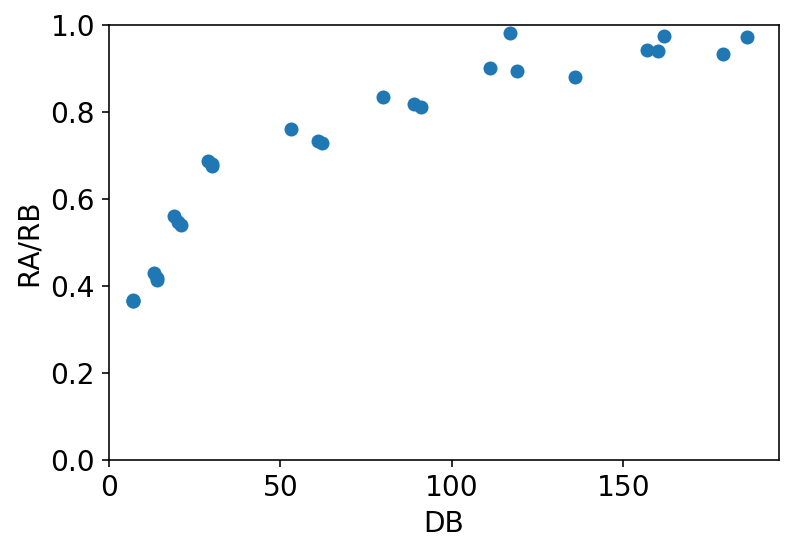

In [7]:
mcq = pd.read_csv("../discounting questions/study1_mcq.csv")

# IMPORTANT: Ensure rows are sorted by `order`
mcq = mcq.sort_values(by="order")

plot_questions(mcq)

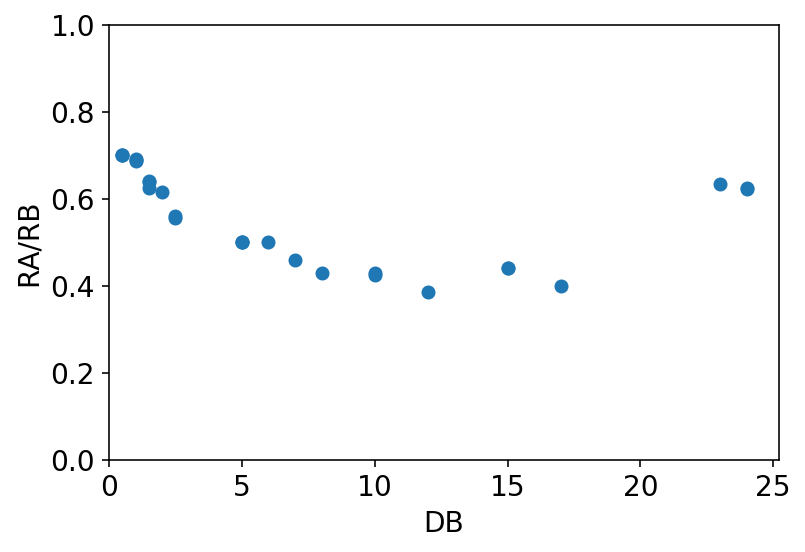

In [8]:
fcq = pd.read_csv("../discounting questions/study1_fcq.csv")

# IMPORTANT: Ensure rows are sorted by `order`
fcq = fcq.sort_values(by="order")

plot_questions(fcq)

## Data extraction functions
These functions will get the responses from the raw data file, and combine them together with the MCQ or WCQ questions we imported.

In [9]:
def extract_MCQ_data(data, row):
    id = data.iloc[row, :].URN
    df = mcq
    df["R"] = (data.iloc[row, data.columns.str.contains("MCQ")] - 1).values
    # force to be numeric
    df = df.astype(float)
    return (id, df)

In [10]:
def extract_FCQ_data(data, row):
    id = data.iloc[row, :].URN
    df = fcq
    df["R"] = (data.iloc[row, data.columns.str.contains("FCQ")] - 1).values
    # force to be numeric
    df = df.astype(float)
    return (id, df)

# Build our Bayesian model
We will use the `pm.Data` class so that we can build one model only, then use it multiple times to fit data from each participant seperately. This should make things more efficient, avoiding building the same model hundreds of times.

In [11]:
def V(reward, delay, logk):
    """Calculate the present subjective value of a given prospect"""
    k = pm.math.exp(logk)
    return reward * discount_function(delay, k)


def discount_function(delay, k):
    """ Hyperbolic discount function """
    return 1 / (1.0 + (k * delay))


def Φ(VA, VB, ϵ=0.01):
    """Psychometric function which converts the decision variable (VB-VA)
    into a reponse probability. Output corresponds to probability of choosing
    the delayed reward (option B)."""
    return ϵ + (1.0 - 2.0 * ϵ) * (1 / (1 + pm.math.exp(-1.7 * (VB - VA))))

In [12]:
def build_model(data):
    with pm.Model() as model:

        # data nodes
        RA = pm.Data("RA", data.RA.values)
        RB = pm.Data("RB", data.RB.values)
        DB = pm.Data("DB", data.DB.values)
        R = pm.Data("R", data.R.values)

        # prior
        logk = pm.Normal("logk", mu=-3, sd=2)

        # response probability
        P = pm.Deterministic("P", Φ(RA, V(RB, DB, logk)))

        # likelihood
        response = pm.Bernoulli("response", p=P, observed=R)

    return model


# in order to build the model we need some example data
participant = 0
temp_trial_data = extract_MCQ_data(data, participant)[1]
temp_trial_data

# Now build the model at last
model = build_model(temp_trial_data)

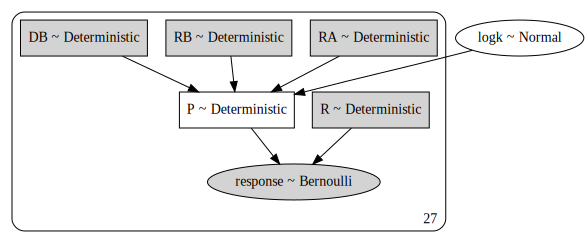

In [13]:
pm.model_to_graphviz(model)

In [14]:
def score_participant(data, plot=False):
    """Our core function to score a participant"""

    with model:
        # set the data
        pm.set_data({"RA": data.RA, "RB": data.RB, "DB": data.DB, "R": data.R})

        # do the sampling
        trace = pm.sample(**sample_options)

    logk_mean = np.mean(trace["logk"])

    if plot:
        fig, ax = plt.subplots(figsize=(6, 4))
        plot_data(data, ax=ax)
        plot_discount_func(ax, data, trace)
        plt.show()

    return logk_mean

## Test: scoring of individual participant

In [15]:
participant = 1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1804.05draws/s]
The number of effective samples is smaller than 10% for some parameters.


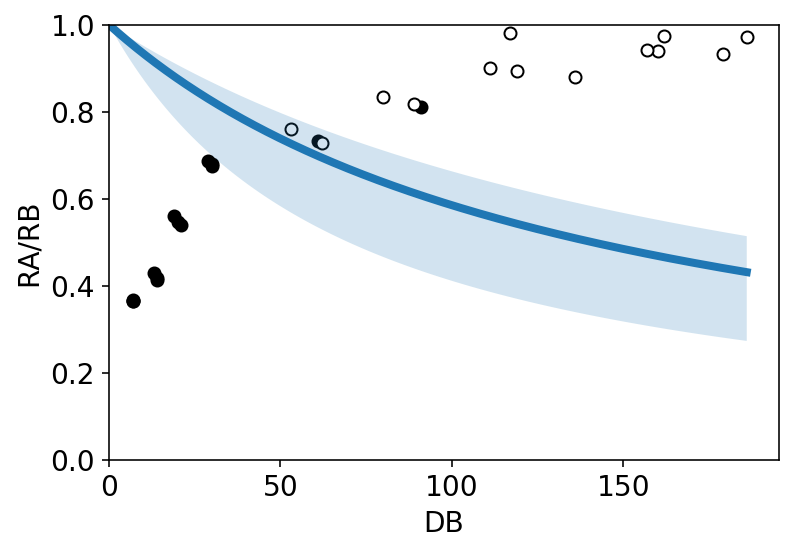

-4.948210303198153

In [16]:
temp_trial_data = extract_MCQ_data(data, participant)[1]
score_participant(temp_trial_data, plot=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1961.98draws/s]
The number of effective samples is smaller than 25% for some parameters.


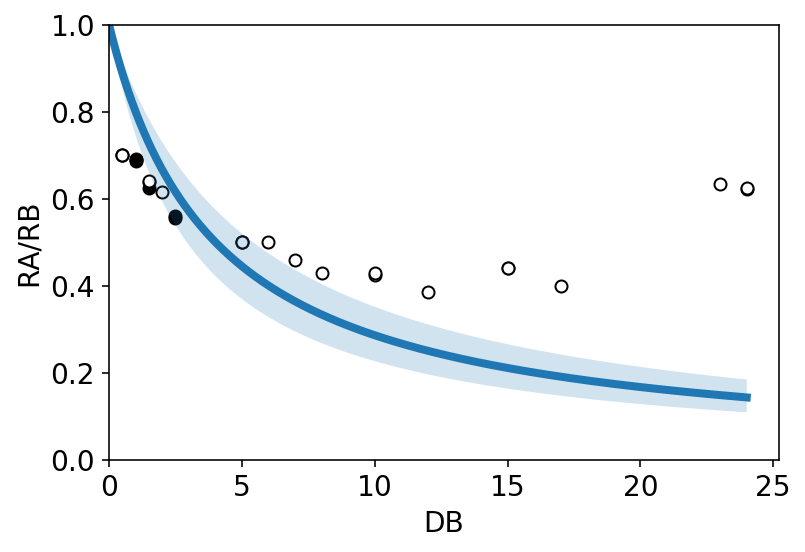

-1.3871857906882026

In [17]:
temp_trial_data = extract_FCQ_data(data, participant)[1]
score_participant(temp_trial_data, plot=True)

## Plot in a different way

In [18]:
# temp_trial_data = extract_FCQ_data(data, participant)[1]

# fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# for mag, title in zip([1, 2, 3], ["small", "medium", "large"]):
#     # subset rows by magnitude
#     temp = temp_trial_data.loc[temp_trial_data["mag"] == mag]

#     k_indif = ((temp.RB / temp.RA) - 1) / temp.DB
#     logk_indif = np.log(k_indif)

#     ax[mag - 1].scatter(k_indif, temp.R)
#     ax[mag - 1].set(
#         xlabel="indifference $\log(k)$",
#         ylabel="P(choose delayed)",
#         ylim=[-0.05, 1.05],
#         title=title,
#     )

# Iterate over participants

In [19]:
n_participants = data.shape[0]

should_plot = False

pid = []
logk_mcq = []
logk_fcq = []

for i in range(n_participants):

    # mcq
    id_num1, mcq_trial_data = extract_MCQ_data(data, i)
    print(id_num1)
    logk_mcq_value = score_participant(mcq_trial_data, plot=should_plot)
    logk_mcq.append(logk_mcq_value)

    # fcq
    id_num2, fcq_trial_data = extract_FCQ_data(data, i)
    assert id_num1 is id_num2, print("ID values don't match up")
    logk_fcq_value = score_participant(fcq_trial_data, plot=should_plot)
    logk_fcq.append(logk_fcq_value)

    pid.append(id_num2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53904018


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1579.57draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1530.54draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53903992


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1667.11draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1494.04draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53904586


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:07<00:00, 1054.01draws/s]
The acceptance probability does not match the target. It is 0.8842086072019453, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1534.82draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53904603


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1302.39draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2189.48draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53905774


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2035.59draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:08<00:00, 976.22draws/s] 
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53906899


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1487.20draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2046.46draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53907410


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2238.54draws/s]
The acceptance probability does not match the target. It is 0.869108479736912, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946643685292904, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2031.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53907558


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1700.10draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2042.61draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53907706


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1563.68draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2351.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53908024


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1735.65draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2247.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53909336


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2055.46draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1352.06draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53909476


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2060.54draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2002.03draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53909554


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2104.21draws/s]
The acceptance probability does not match the target. It is 0.8986902104078737, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8822627854108406, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1728.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53910988


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1638.87draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2268.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53910919


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1937.27draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1271.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53911275


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1587.93draws/s]
The acceptance probability does not match the target. It is 0.8731492101885245, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1961.97draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53911351


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2173.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2212.28draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53912235


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1581.67draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1608.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53913596


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1752.03draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1623.90draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53914998


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1611.83draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2497.16draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53915136


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2078.49draws/s]
The acceptance probability does not match the target. It is 0.8959444484720451, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1324.93draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53915132


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2108.01draws/s]
The acceptance probability does not match the target. It is 0.9070093744470502, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2220.57draws/s]
The acceptance probability does not match the target. It is 0.7948423532635284, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53915172


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1653.13draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2362.76draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53914836


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2027.11draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2044.07draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53915201


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1721.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2133.70draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53915926


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1723.06draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1480.37draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53916734


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1828.67draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2035.06draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53916938


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2077.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2621.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53917953


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1978.40draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2332.03draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53917890


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1644.24draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2239.48draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53918260


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2342.54draws/s]
The acceptance probability does not match the target. It is 0.8600239263631225, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2025.50draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53918374


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2034.58draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2276.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53918535


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2031.56draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2377.89draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53918662


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1418.60draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2607.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53918303


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2147.58draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2618.34draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53919098


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1917.74draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2379.94draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53919835


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1821.41draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1660.21draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53920147


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2217.81draws/s]
The acceptance probability does not match the target. It is 0.9003133748585509, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2478.20draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53920079


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1788.68draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2658.84draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53920513


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1485.08draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1738.47draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53920482


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2134.21draws/s]
The acceptance probability does not match the target. It is 0.8077433870800884, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2245.61draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53920798


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1928.81draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1987.19draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53920922


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2228.72draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2667.61draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53921036


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2393.64draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1439.45draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53921166


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1831.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2586.23draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53926557


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1928.05draws/s]
The acceptance probability does not match the target. It is 0.8814840114348469, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1949.13draws/s]
The acceptance probability does not match the target. It is 0.8594871875951684, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53932693


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2363.70draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2459.24draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53935407


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2318.60draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2251.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53936310


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1888.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1220.03draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53936437


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1785.20draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2247.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53940969


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2243.94draws/s]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2300.84draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53941273


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2174.85draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2601.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53946013


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2437.63draws/s]
The acceptance probability does not match the target. It is 0.8077433870800884, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1842.99draws/s]
The acceptance probability does not match the target. It is 0.818081778447825, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53949815


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2371.12draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2492.36draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53951728


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2067.85draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2588.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53954642


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2130.96draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2398.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53954999


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1707.87draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2288.17draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53955146


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1808.59draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2458.05draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53956105


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2467.78draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1756.49draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53958137


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2456.15draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1866.14draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53961214


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2274.85draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2554.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53964750


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1794.41draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2689.13draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53965512


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1878.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2248.11draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53966154


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2365.99draws/s]
The acceptance probability does not match the target. It is 0.8077433870800884, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2533.05draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53966715


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1777.07draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2053.64draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53975708


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1805.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2587.68draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53976455


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1759.96draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2214.83draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-53992880


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2330.95draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1717.42draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54001678


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2281.40draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2516.49draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54005567


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1990.12draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2570.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54008258


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1730.50draws/s]
The acceptance probability does not match the target. It is 0.8364506488560317, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1531.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54009429


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1781.71draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2673.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54012836


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1803.29draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2500.76draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54013134


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2223.94draws/s]
The acceptance probability does not match the target. It is 0.8709137235973149, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1375.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54014564


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1864.95draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2354.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54015087


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2304.99draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2496.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54015681


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2127.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2574.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54019933


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2299.89draws/s]
The acceptance probability does not match the target. It is 0.8539338041228719, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1768.90draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54020394


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1511.95draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1602.15draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54020327


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2174.53draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2575.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54020648


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1322.84draws/s]
The acceptance probability does not match the target. It is 0.8842086072019453, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1776.55draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54020890


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2100.77draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2312.95draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54021142


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2376.71draws/s]
The acceptance probability does not match the target. It is 0.8600239263631225, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1856.57draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54021516


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2356.00draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2723.12draws/s]
The acceptance probability does not match the target. It is 0.3827699783664154, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54021940


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1988.33draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1718.69draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54022583


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1867.86draws/s]
The acceptance probability does not match the target. It is 0.8206002768800501, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1733.97draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54026183


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1764.21draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2559.40draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54030050


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1384.45draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2465.80draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54035337


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2108.97draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2178.95draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54035625


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2057.72draws/s]
The acceptance probability does not match the target. It is 0.8623013989080273, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2633.75draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54038457


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2251.41draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2089.07draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54047713


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2520.06draws/s]
The acceptance probability does not match the target. It is 0.7886109221747051, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1392.73draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54048008


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2006.83draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2389.21draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54057089


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2264.64draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2515.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54058300


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1859.56draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2405.47draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54059265


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2186.42draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2570.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54059056


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2310.58draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1973.93draws/s]
The acceptance probability does not match the target. It is 0.6579611120523985, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54059444


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1679.24draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1479.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54061912


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2254.09draws/s]
The acceptance probability does not match the target. It is 0.8600239263631225, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1745.91draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54062307


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1364.45draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2263.14draws/s]
The acceptance probability does not match the target. It is 0.7233712973336066, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54062526


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2122.98draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2610.45draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54062161


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1517.86draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2484.09draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54064106


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2499.93draws/s]
The acceptance probability does not match the target. It is 0.7886109221747051, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2196.38draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54064347


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2282.70draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2324.15draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54066398


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2483.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2536.21draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54067591


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2002.31draws/s]
The acceptance probability does not match the target. It is 0.8364506488560317, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2765.70draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54067613


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2440.24draws/s]
The acceptance probability does not match the target. It is 0.9070110317149354, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1625.91draws/s]
The acceptance probability does not match the target. It is 0.9945758678695396, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8258371262236608, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using 

550455-550446-54067829


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2654.88draws/s]
The acceptance probability does not match the target. It is 0.869108479736912, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946643685292904, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2430.60draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54066904


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2100.75draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2701.62draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54067919


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1885.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1759.03draws/s]
The acceptance probability does not match the target. It is 0.8277867143283032, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54068124


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2300.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2744.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54067905


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1937.91draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2255.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54068897


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2074.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1520.67draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54069041


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2253.27draws/s]
The acceptance probability does not match the target. It is 0.8154429899934754, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2398.63draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54069213


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1848.02draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1784.01draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54069280


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2419.50draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2516.04draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54070541


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1911.08draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2086.31draws/s]
The acceptance probability does not match the target. It is 0.9055910361354134, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54070719


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1728.86draws/s]
The acceptance probability does not match the target. It is 0.852730264933332, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2546.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54070692


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1568.15draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2654.65draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54071660


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2350.44draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2458.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54071739


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1847.51draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2190.67draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54072059


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1783.55draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2767.66draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54072045


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2380.53draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1829.75draws/s]
The acceptance probability does not match the target. It is 0.8585705021056631, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54073344


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1818.20draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2396.65draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54075403


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2222.89draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2501.70draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54077073


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2462.43draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2595.02draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54077205


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2089.68draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1880.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54078364


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2207.29draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2465.47draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54078513


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2162.03draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2235.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54079064


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2322.55draws/s]
The acceptance probability does not match the target. It is 0.8656223640314893, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2201.60draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54079862


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2322.01draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2663.06draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54077828


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1942.55draws/s]
The acceptance probability does not match the target. It is 0.8364506488560317, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2756.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54082334


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2013.50draws/s]
The acceptance probability does not match the target. It is 0.8364506488560317, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2698.91draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54084243


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2087.50draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2625.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54086831


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1925.47draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2274.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54087968


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1872.04draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2702.07draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54089556


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2406.82draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1793.30draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54091407


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2491.36draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2732.44draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54090779


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2484.98draws/s]
The acceptance probability does not match the target. It is 0.7886109221747051, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2657.70draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54092551


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2339.91draws/s]
The acceptance probability does not match the target. It is 0.8127043012258006, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2756.74draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54092848


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2363.15draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2256.61draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54097004


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2255.35draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1476.20draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54098846


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2560.19draws/s]
The acceptance probability does not match the target. It is 0.8600239263631225, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2165.37draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54102209


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2491.87draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1464.58draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54103317


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1844.26draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2248.10draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54104437


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1598.10draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2190.24draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54104665


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2376.23draws/s]
The acceptance probability does not match the target. It is 0.9077602781319225, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1804.62draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54114804


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1577.66draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2793.47draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54115989


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2296.37draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2676.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54127561


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1725.37draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1687.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54127645


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1977.51draws/s]
The acceptance probability does not match the target. It is 0.8949075104108841, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2111.58draws/s]
The acceptance probability does not match the target. It is 0.9068004232363048, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54128116


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2227.56draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1477.12draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54130114


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2045.70draws/s]
The acceptance probability does not match the target. It is 0.8801440320495586, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2623.84draws/s]
The acceptance probability does not match the target. It is 0.9061802173378686, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54132458


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1857.15draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2619.76draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54132553


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1884.62draws/s]
The acceptance probability does not match the target. It is 0.8482013037890768, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2679.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54160500


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2410.18draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2653.99draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54182283


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2495.51draws/s]
The acceptance probability does not match the target. It is 0.22664181230699096, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.802759171170034, but should be close to 0.95. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2341.04draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54181381


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2500.87draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1973.96draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54191057


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1463.01draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2026.28draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54203044


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2381.04draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2458.65draws/s]
The acceptance probability does not match the target. It is 0.7964256661760255, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54203967


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2393.18draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1446.92draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54217135


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2400.31draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1830.71draws/s]
The acceptance probability does not match the target. It is 0.7761439893900414, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54218151


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2664.40draws/s]
The acceptance probability does not match the target. It is 0.7987757145100423, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.615813034965641, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2673.47draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54220963


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1668.45draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2700.95draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54221224


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2117.04draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2026.92draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54220661


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1870.17draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2493.37draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54222420


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2389.73draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1449.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54225072


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2457.14draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1479.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54225518


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1970.67draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2648.46draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54226613


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2358.06draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1960.37draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54319685


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2339.55draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2735.18draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54342392


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2473.52draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2545.70draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54407107


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1840.81draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2087.75draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54413523


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2177.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1735.53draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54417830


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2350.82draws/s]
The acceptance probability does not match the target. It is 0.8656223640314893, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1831.22draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54418874


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2345.02draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2686.08draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54419272


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1867.48draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2785.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54419847


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2393.86draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1839.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54420351


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1869.18draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2643.68draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54420214


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1967.18draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2358.16draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54422072


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1561.42draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2237.22draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54421380


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2394.26draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2310.24draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54423442


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1939.53draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2370.56draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54424143


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2154.71draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1774.93draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54424162


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2248.32draws/s]
The acceptance probability does not match the target. It is 0.8306319979784488, but should be close to 0.95. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2650.21draws/s]
The acceptance probability does not match the target. It is 0.9005888781400381, but should be close to 0.95. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54424448


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2274.40draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2785.43draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54424608


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1814.16draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2507.25draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54424411


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2345.27draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2729.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54424883


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2027.18draws/s]
The acceptance probability does not match the target. It is 0.8364506488560317, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1441.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54425359


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2177.17draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1944.40draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54425254


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2300.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2476.12draws/s]
The acceptance probability does not match the target. It is 0.8938708723696289, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54426888


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1697.80draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2191.21draws/s]
The acceptance probability does not match the target. It is 0.4138003356666101, but should be close to 0.95. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54427058


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2634.49draws/s]
The acceptance probability does not match the target. It is 0.869108479736912, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946643685292904, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2703.53draws/s]
The acceptance probability does not match the target. It is 0.8479503645433921, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using j

550455-550446-54429683


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1715.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1802.03draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54430298


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1948.49draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2658.58draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54430384


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2387.37draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2557.88draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54430630


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2443.36draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2335.17draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54430891


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2433.65draws/s]
The acceptance probability does not match the target. It is 0.8600239263631225, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2617.31draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54428631


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2070.68draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2627.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54433229


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2642.56draws/s]
The acceptance probability does not match the target. It is 0.7987757145100423, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.615813034965641, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2800.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54434917


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2262.10draws/s]
The acceptance probability does not match the target. It is 0.8943635817759462, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2749.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54437655


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1991.59draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1842.36draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54444961


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2162.16draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2586.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54445759


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2378.81draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2476.39draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54451135


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1569.46draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2328.93draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54454186


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2056.34draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2635.05draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54460379


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2464.53draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2070.20draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54461382


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2254.81draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2019.09draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54463232


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2265.44draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2615.27draws/s]
The acceptance probability does not match the target. It is 0.8449730270898141, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8118129882525787, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54483108


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2131.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2246.58draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54490956


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1962.19draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1933.23draws/s]
The acceptance probability does not match the target. It is 0.8594871875951684, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54495868


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1991.44draws/s]
The acceptance probability does not match the target. It is 0.8993297233033708, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2585.83draws/s]
The acceptance probability does not match the target. It is 0.8850813562037319, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8888318247091157, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing N

550455-550446-54497563


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2356.12draws/s]
The acceptance probability does not match the target. It is 0.8943635469482651, but should be close to 0.95. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1823.36draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54503350


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2007.69draws/s]
The acceptance probability does not match the target. It is 0.8364506488560317, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2767.41draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54517934


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1820.37draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2700.64draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54523785


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1359.84draws/s]
The acceptance probability does not match the target. It is 0.8842086072019453, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1826.12draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54537434


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2469.06draws/s]
The acceptance probability does not match the target. It is 0.8077433870800884, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2157.19draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54540505


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2237.69draws/s]
The acceptance probability does not match the target. It is 0.9076069777616991, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2778.37draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54544941


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1524.37draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2943.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54586604


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2406.28draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2764.15draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54587158


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1997.07draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1884.23draws/s]
The acceptance probability does not match the target. It is 0.9012071398327247, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54596555


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2364.59draws/s]
The acceptance probability does not match the target. It is 0.8077433870800884, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1976.68draws/s]
The acceptance probability does not match the target. It is 0.8594871875951684, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54622935


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1891.11draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2813.24draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54623080


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1828.12draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2035.57draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54628712


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2009.33draws/s]
The acceptance probability does not match the target. It is 0.8364506488560317, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1479.56draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54634626


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1956.69draws/s]
The acceptance probability does not match the target. It is 0.8364506488560317, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2279.30draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54634617


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2136.88draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2633.94draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54634999


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2395.01draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2212.79draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54635592


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2451.42draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1809.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54635925


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2469.67draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1475.88draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54636066


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2028.67draws/s]
The acceptance probability does not match the target. It is 0.8801440320495586, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2535.90draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54636107


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2542.05draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2403.62draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54636488


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1770.53draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1940.33draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54636527


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1638.69draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1370.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54636621


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2295.69draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1703.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54636786


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2402.53draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2676.00draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54637147


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2279.07draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2679.41draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54637436


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2591.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2560.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54637496


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1865.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1804.28draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54638080


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2267.61draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1711.02draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54639145


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1719.84draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1712.08draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54640797


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1829.10draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2802.42draws/s]
The acceptance probability does not match the target. It is 0.8799289658932603, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54644125


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1509.46draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2185.97draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54644873


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1612.51draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2439.75draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54648085


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1531.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2752.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54667399


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2348.12draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2215.12draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54692085


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1737.25draws/s]
The acceptance probability does not match the target. It is 0.8706783480561949, but should be close to 0.95. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2435.77draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54693409


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2409.17draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1983.72draws/s]
The acceptance probability does not match the target. It is 0.8624659085393023, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7469979500650831, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54694236


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2381.05draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1466.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54695423


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2534.77draws/s]
The acceptance probability does not match the target. It is 0.869108479736912, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946643685292904, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2437.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54697503


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1458.88draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2686.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54698190


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2372.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1905.98draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54702332


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2516.57draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1813.26draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54704384


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2500.72draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1487.84draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54704660


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1981.40draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1568.92draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54705168


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2036.49draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2856.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54706757


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2246.68draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2679.90draws/s]
The acceptance probability does not match the target. It is 0.8675040615848716, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54707257


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2324.82draws/s]
The acceptance probability does not match the target. It is 0.8237201548543411, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1547.86draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54709427


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1951.15draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2388.95draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54711357


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2129.53draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1866.78draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54735781


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2375.11draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2368.04draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54736811


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2362.58draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1788.90draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54737603


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2434.25draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2646.18draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54738769


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2293.11draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2573.30draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54739430


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2503.04draws/s]
The acceptance probability does not match the target. It is 0.8600239263631225, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2551.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54740468


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2297.69draws/s]
The acceptance probability does not match the target. It is 0.8259066816442815, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1624.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54740693


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2399.66draws/s]
The acceptance probability does not match the target. It is 0.5865237292336122, but should be close to 0.95. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2333.84draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54740869


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1570.28draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2605.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54742522


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2061.42draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2663.97draws/s]
The acceptance probability does not match the target. It is 0.8983090110297347, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54743244


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2252.65draws/s]
The acceptance probability does not match the target. It is 0.9077602781297889, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1635.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54744478


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2412.40draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2235.05draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54744630


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2056.34draws/s]
The acceptance probability does not match the target. It is 0.8678087274264673, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1841.19draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54745064


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2080.29draws/s]
The acceptance probability does not match the target. It is 0.8943635469482651, but should be close to 0.95. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2358.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54747381


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2494.04draws/s]
The acceptance probability does not match the target. It is 0.8077433870800884, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1788.08draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54746122


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2424.88draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2637.38draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54748717


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2353.87draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2531.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54751166


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2110.96draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2728.84draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54751522


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2005.63draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1851.24draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54757001


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2452.46draws/s]
The acceptance probability does not match the target. It is 0.9077602781319225, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2483.58draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54757739


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2428.82draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2075.93draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54759236


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2477.31draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1467.92draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54761173


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1543.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2520.66draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54760954


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:08<00:00, 970.06draws/s] 
The acceptance probability does not match the target. It is 0.994604148255985, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8314166269694288, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2194.87draws/s]
The acceptance probability does not match the target. It is 0.8353519180280576, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NU

550455-550446-54763011


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2292.26draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2649.26draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54766963


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2330.48draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2359.68draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54768836


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1225.74draws/s]
The acceptance probability does not match the target. It is 0.8842086072019453, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1826.39draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54772345


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2508.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1489.60draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54775447


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1849.68draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1781.55draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54783725


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2362.56draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2782.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54784024


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2563.47draws/s]
The acceptance probability does not match the target. It is 0.7886109221747051, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2108.97draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54786101


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2060.11draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2807.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54792692


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1366.27draws/s]
The acceptance probability does not match the target. It is 0.8842086072019453, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1875.84draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54793974


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2328.45draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1838.77draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54795376


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1548.68draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2619.13draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54802690


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2172.67draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2563.18draws/s]
The acceptance probability does not match the target. It is 0.8995992018593827, but should be close to 0.95. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54806638


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2380.30draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1920.46draws/s]
The acceptance probability does not match the target. It is 0.880636496846249, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54808574


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1794.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2401.64draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54830631


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2192.56draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1320.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54831889


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2572.18draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2448.45draws/s]
The acceptance probability does not match the target. It is 0.8931414620558482, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54851877


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2033.29draws/s]
The acceptance probability does not match the target. It is 0.8364506488560317, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2799.73draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54867322


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2331.75draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2415.07draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54867625


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1760.78draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2176.77draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54870909


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1822.34draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2796.41draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54876902


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1937.82draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1969.79draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54875905


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1857.53draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2390.42draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54877994


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2722.56draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1442.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54880172


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2002.15draws/s]
The acceptance probability does not match the target. It is 0.8364506488560317, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2695.81draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54901463


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1880.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2571.12draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54908574


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2081.66draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2728.25draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54909499


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2430.07draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1687.27draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54915351


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2268.62draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2522.04draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54953791


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1973.12draws/s]
The acceptance probability does not match the target. It is 0.8600239263631225, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2342.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54964272


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2360.34draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2449.20draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54994611


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2503.03draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1466.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-54996995


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2398.21draws/s]
The acceptance probability does not match the target. It is 0.8702282333928949, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2295.14draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55018401


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1549.82draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1805.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55019650


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2349.03draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1916.45draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55039994


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1719.72draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1357.93draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55053236


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2454.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2547.10draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55053471


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2192.76draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1725.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55053754


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2380.84draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2537.79draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55054587


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1928.21draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2803.17draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55055021


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2403.91draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1474.71draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55055463


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1578.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2144.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55059703


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2161.15draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2403.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55059911


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1703.18draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2478.10draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55060884


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2504.05draws/s]
The acceptance probability does not match the target. It is 0.7947087736606563, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1438.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55062320


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2513.08draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2704.55draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55063015


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2381.71draws/s]
The acceptance probability does not match the target. It is 0.8176076826888015, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.90301042399146, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2620.21draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55063430


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2594.85draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2633.43draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55065898


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2120.01draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2493.99draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55066315


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2394.18draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2586.49draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55066365


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2571.46draws/s]
The acceptance probability does not match the target. It is 0.869108479736912, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946643685292904, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2054.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55066174


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2386.78draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1484.25draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55066367


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2177.02draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1776.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55067168


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2486.64draws/s]
The acceptance probability does not match the target. It is 0.8077433870800884, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2628.36draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55069755


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2096.85draws/s]
The acceptance probability does not match the target. It is 0.9077602781319225, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2419.96draws/s]
The acceptance probability does not match the target. It is 0.9076451681254758, but should be close to 0.95. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55069739


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1727.78draws/s]
The acceptance probability does not match the target. It is 0.9931300156405204, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9057253436706265, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1652.73draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55070613


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2346.97draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2742.25draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55071656


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:14<00:00, 548.36draws/s] 
The acceptance probability does not match the target. It is 0.9995261893427478, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1338.86draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55067251


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2089.25draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1768.68draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55073203


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2350.27draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1804.55draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55073604


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2402.77draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2656.74draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55073681


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2535.15draws/s]
The acceptance probability does not match the target. It is 0.8841000020070693, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8339757950703913, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1803.70draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55073770


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1845.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2668.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55073771


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2363.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2304.22draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55073961


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1616.03draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1673.86draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55074022


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1804.74draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2679.34draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55074415


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1986.63draws/s]
The acceptance probability does not match the target. It is 0.8364506488560317, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2822.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55074497


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1573.77draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2272.56draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55074538


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2033.53draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1823.37draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55074699


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2016.98draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2507.26draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55074966


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1855.42draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2310.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55075147


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2412.81draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1867.90draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55075480


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2503.97draws/s]
The acceptance probability does not match the target. It is 0.8655334774538593, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2232.75draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55077052


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1995.30draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1774.85draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55077724


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1752.41draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2649.55draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55075132


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1810.89draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2611.32draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55079211


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2345.68draws/s]
The acceptance probability does not match the target. It is 0.8840023984763523, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.825777889078645, but should be close to 0.95. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2555.87draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55079321


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1792.70draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2716.41draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55079483


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1995.86draws/s]
The acceptance probability does not match the target. It is 0.8364506488560317, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1769.70draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55079396


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1468.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2576.64draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55080133


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2274.48draws/s]
The acceptance probability does not match the target. It is 0.869108479736912, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946643685292904, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2534.34draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55081312


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1607.24draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1800.04draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55083117


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1828.95draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1977.99draws/s]
The acceptance probability does not match the target. It is 0.8594871875951684, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55083893


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2552.04draws/s]
The acceptance probability does not match the target. It is 0.869108479736912, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946643685292904, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2763.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55084758


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1921.15draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2774.88draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55086417


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2146.42draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1461.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55089069


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2144.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2660.71draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55092165


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2438.89draws/s]
The acceptance probability does not match the target. It is 0.8600239263631225, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2661.81draws/s]
The acceptance probability does not match the target. It is 0.4031758431894739, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55092433


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2253.12draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1607.36draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55093452


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2222.87draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2015.56draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55093530


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1834.07draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1808.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55093551


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1547.42draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2493.06draws/s]
The acceptance probability does not match the target. It is 0.8850813562037319, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8888318247091157, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55093866


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2425.37draws/s]
The acceptance probability does not match the target. It is 0.9008813717765156, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2642.13draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55095224


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2228.16draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1760.19draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55099340


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2474.78draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1766.53draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55100400


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2206.65draws/s]
The acceptance probability does not match the target. It is 0.8943635817759462, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2623.44draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55106208


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2470.42draws/s]
The acceptance probability does not match the target. It is 0.8517595292993697, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1784.93draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55110418


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2481.04draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2083.99draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55133558


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1973.91draws/s]
The acceptance probability does not match the target. It is 0.8364506488560317, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2177.08draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55135291


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2188.03draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2766.16draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55146009


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2315.30draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2758.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55148768


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1602.99draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1752.32draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55146607


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1956.32draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2627.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55149514


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2033.18draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1625.36draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55150850


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2223.45draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2851.43draws/s]
The acceptance probability does not match the target. It is 0.8609018055767121, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55153380


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1530.28draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2586.15draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55155927


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1360.66draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2234.39draws/s]
The acceptance probability does not match the target. It is 0.89717614372255, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55156715


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2450.94draws/s]
The acceptance probability does not match the target. It is 0.869108479736912, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946643685292904, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1783.07draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55157716


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1526.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2590.97draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55167281


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2145.11draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2598.73draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55172100


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2493.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2517.74draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55176660


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2453.72draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2060.58draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55187408


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2079.06draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2588.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55187382


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2557.32draws/s]
The acceptance probability does not match the target. It is 0.704801651462207, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8039085264859899, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2337.80draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55189168


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2349.86draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2627.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55193260


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2236.41draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2128.22draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55193616


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2515.24draws/s]
The acceptance probability does not match the target. It is 0.869108479736912, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946643685292904, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2821.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55194053


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1831.51draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1643.14draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55194235


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2375.06draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1991.68draws/s]
The acceptance probability does not match the target. It is 0.9059304164066937, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55196438


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2256.38draws/s]
The acceptance probability does not match the target. It is 0.9003133748585509, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2029.91draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55198614


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2080.69draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2550.18draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55198379


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2290.31draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2589.79draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55218490


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1654.35draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2511.69draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55220406


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2175.35draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2317.20draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55227221


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2231.65draws/s]
The acceptance probability does not match the target. It is 0.8661218630250428, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2528.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55250014


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1588.18draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2555.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55251141


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2117.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2233.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55251801


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1801.00draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2643.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55252970


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1608.97draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2771.76draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55279229


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2491.65draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1597.58draws/s]
The acceptance probability does not match the target. It is 0.7977761926433043, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55289659


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2469.50draws/s]
The acceptance probability does not match the target. It is 0.8077433870800884, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2428.49draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55312067


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1967.85draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2625.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55354524


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2074.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2739.51draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


550455-550446-55359642


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2234.99draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2439.36draws/s]


In [20]:
results = pd.DataFrame({"URN": pid, "logk_mcq": logk_mcq, "logk_fcq": logk_fcq})

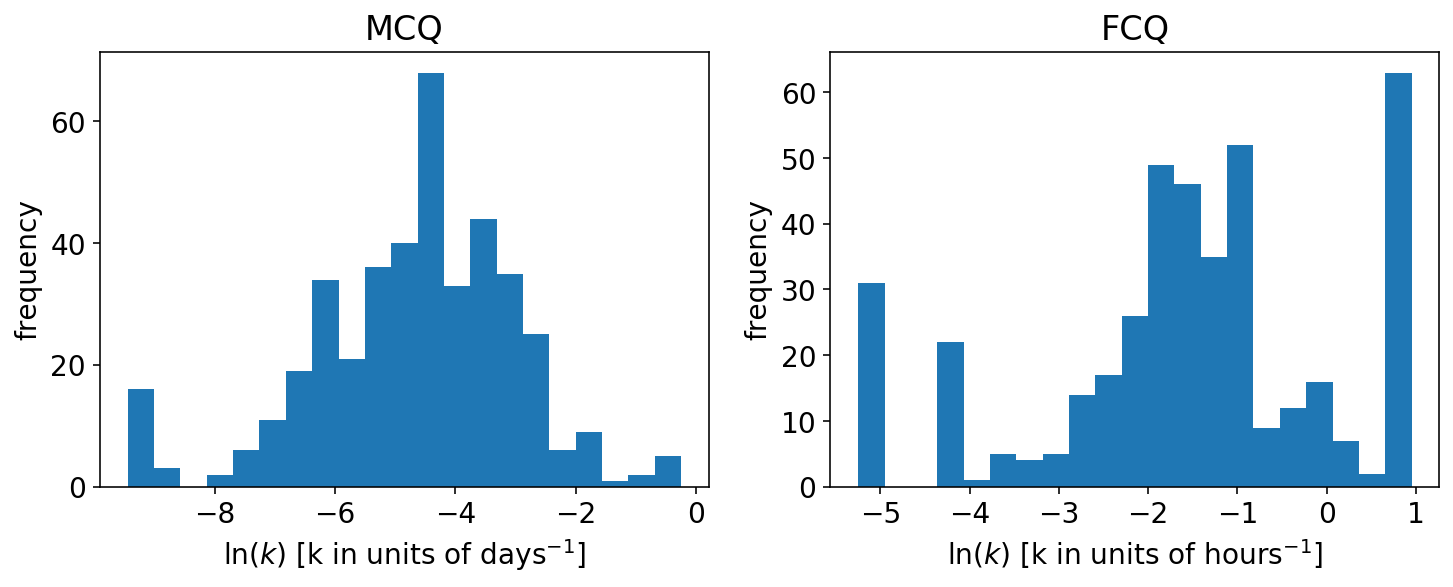

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=False)

bins = 21

ax[0].hist(logk_mcq, bins)
ax[0].set(
    xlabel="$\ln(k)$ [k in units of days$^{-1}$]", ylabel="frequency", title="MCQ"
)

ax[1].hist(logk_fcq, bins)
ax[1].set(
    xlabel="$\ln(k)$ [k in units of hours$^{-1}$]", ylabel="frequency", title="FCQ"
)

# increased space between rows
plt.subplots_adjust(hspace=0.4)

plt.savefig("../study1_fit_histograms.pdf", bbox_inches="tight", dpi=300)

In [22]:
results.head()

,URN,logk_mcq,logk_fcq
0,550455-550446-53904018,-3.992296,0.951773
1,550455-550446-53903992,-4.948210,-1.387186
2,550455-550446-53904586,-0.248028,0.951773
3,550455-550446-53904603,-2.744862,-1.872237
4,550455-550446-53905774,-3.356531,-5.125415


In [23]:
# merge with original data file
final = pd.merge(data, results, on="URN")

# remove raw data columns, no longer needed
final = final[final.columns.drop(list(final.filter(regex="MCQ")))]
final = final[final.columns.drop(list(final.filter(regex="FCQ")))]

# export
final.to_csv("study1_final_data.csv", index=False)